**извлечение признаков из текста на естественном языке**

классификатор текстов SnowballStemmer+TfidfVectorizer

Евгений Борисов borisov.e@solarl.ru

## библиотеки

In [1]:
import re
# import gzip
import numpy as np
import numpy.random as rng
import pandas as pd
from tqdm import tqdm

np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth = 200 

tqdm.pandas()

/usr/lib/python3.8/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
# import numpy as np
# import pandas as pd
# import re

In [3]:
from sklearn import __version__ as SKLEARN_VERSION

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

SKLEARN_VERSION

'0.23.2'

In [4]:
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as nltk_stopwords
# from nltk import download as nltk_download
# nltk_download('stopwords')

## тексты

In [5]:
# загружаем тексты
data = pd.read_pickle('../data/news.pkl.gz')
print('записей:',len(data))
data.sample(2)

записей: 3196


,text,tag
2089,"Выделите ее и нажмите Ctrl+Enter, чтобы сообщить об этом редакции.\n\n© ФК Шахтер\n\nФутболисты киевского ""Динамо"" и донецкого ""Шахтера"" устроили потасовку во время центрального матча 18-го тура ч...",sport
2374,"Водитель оставил машину и скрылся с места происшествия.\n\nНа западе Москвы, в районе Раменки, водитель автомобиля Mercedes совершил наезд на двух школьниц. Об этом во вторник, 13 декабря, сообщил...",incident


## токенизация и очистка

In [6]:
# применяет список замен pat к строке s
def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

# нормализация текста
def text_normalizer(s):
    pat = [
       [r'ё','е'] # замена ё для унификации
       ,[r'</?[a-z]+>',' '] # удаляем xml
       ,[r'\d+',' '] # удаляем цифры
       ,[r'[\W]+',' '] # удаляем спец.символы
       ,[r' +',' '] # удаляем повторы пробелов
    ]
    
    return replace_patterns(s.lower(),pat).strip()

stopwords = set(nltk_stopwords.words('russian'))
stemmer = SnowballStemmer('russian')

# разрезаем стоки на слова, выкидываем stopwords, выполняем стеминг
def tokenize(s): 
    p = [ stemmer.stem(w).replace('^','') for w in s.split() if ( w not in stopwords ) ]
    return [ w for w in p if (len(w)>1) ]

In [7]:
data['ctext'] = data['text'].progress_apply( text_normalizer )
data['ctext'] = data['ctext'].progress_apply( tokenize )

100%|██████████| 3196/3196 [00:15<00:00, 211.25it/s]


In [8]:
# собираем словарь
vcb0 = [ set(s) for s in data['ctext'].tolist() ]
vcb0 = sorted(set.union(*vcb0))
print('словарь %i слов'%(len(vcb0)))
# pd.DataFrame( vcb0 ).to_csv('voc0.txt',index=False,header=False)

словарь 34990 слов


##  Vectorizer

In [9]:
data['ctext'] = data['ctext'].apply( ' '.join  )

In [10]:
tf = TfidfVectorizer(use_idf=True, norm='l2').fit( data['ctext'] )
vcb1 = sorted(tf.vocabulary_)
print(len(vcb1))
# pd.DataFrame( vcb1 ).to_csv('voc1.txt',index=False,header=False)

34990


## формируем датасеты

In [11]:
X = tf.transform( data['ctext'] )
X.shape

(3196, 34990)

In [12]:
labels = { t:i for i,t in enumerate(sorted(set(data['tag']))) }
labels

{'auto': 0,
 'culture': 1,
 'economics': 2,
 'health': 3,
 'incident': 4,
 'politics': 5,
 'realty': 6,
 'reclama': 7,
 'science': 8,
 'social': 9,
 'sport': 10,
 'tech': 11,
 'woman': 12}

In [13]:
y = data['tag'].map(labels).values
y

array([5, 1, 1, ..., 8, 5, 9])

In [14]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=326 )
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2237, 34990), (2237,), (959, 34990), (959,))

## обучаем классификатор

In [15]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss='hinge',max_iter=1000, tol=0.19)
clf.fit(X_train,y_train)

SGDClassifier(tol=0.19)

## тестируем

In [16]:
o = clf.predict(X_train)

In [17]:
accuracy_score(y_train,o)

0.9995529727313366

In [18]:
o = clf.predict(X_test)

In [19]:
accuracy_score(y_test,o)

0.8821689259645464

In [20]:
print( classification_report(y_test,o) )

              precision    recall  f1-score   support

           0       0.96      0.86      0.91        87
           1       0.82      0.95      0.88       101
           2       0.86      0.83      0.85        76
           3       0.85      0.74      0.79        31
           4       0.86      0.93      0.89       123
           5       0.90      0.95      0.92       177
           6       0.89      0.76      0.82        21
           7       0.82      0.53      0.64        17
           8       0.91      1.00      0.95        68
           9       0.62      0.36      0.46        44
          10       0.98      1.00      0.99       118
          11       0.85      0.84      0.85        89
          12       1.00      0.57      0.73         7

    accuracy                           0.88       959
   macro avg       0.87      0.80      0.82       959
weighted avg       0.88      0.88      0.88       959



---

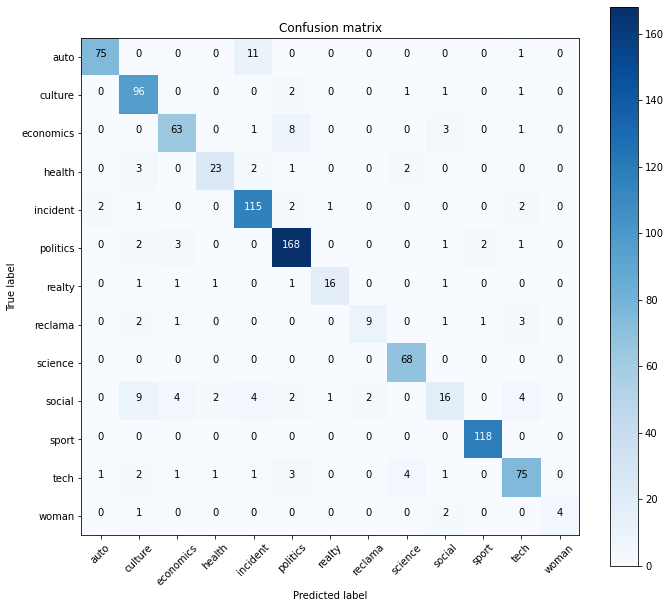

In [21]:
from matplotlib import pyplot as plt
import itertools

classes = sorted(labels.keys())
cm = confusion_matrix(y_test,o)
tick_marks = np.arange(len(classes))

plt.figure(figsize=(10,9))

plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.title('Confusion matrix')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

plt.show()

---

In [22]:
o = clf.predict(X)

In [23]:
labels_inv = { labels[k]:k for k in labels }
# labels_inv

In [24]:
for n in range(10):
    i = rng.randint(len(data))
    print('tag:',data.iloc[i,1])
    print('predict:',labels_inv[o[i]])
    print(re.sub(r'\n\s*\n',' ',data.iloc[i,0][:200])+'...')
    print('- - - - - - - - - - - - - - - - - -')
    

tag: woman
predict: woman
Истории от Юлии Чернявской. Идеалист и его жена 10 декабря 2016 в 16:43 Юлия Чернявская / TUT.BY В детстве я часто бывала в этом доме: мы жили по соседству, и их внуки были моими друзьями. Однажды,...
- - - - - - - - - - - - - - - - - -
tag: incident
predict: incident
Водитель одного из грузовиков выехал на встречную полосу Два человека пострадали в результате ДТП с участием грузовиков, которое произошло в Ростовской области 12 декабря, сообщает РИА «Новости» со с...
- - - - - - - - - - - - - - - - - -
tag: incident
predict: incident
На трассе М1 микроавтобус посольства Польши вылетел в кювет и опрокинулся 8 декабря 2016 в 13:45 Фото: Дарья Бурякина / AUTO.TUT.BY Из-за сложной погодной обстановки на трассе М1 недалеко от съезда...
- - - - - - - - - - - - - - - - - -
tag: economics
predict: economics
Самый богатый венгр стал фаворитом в борьбе за 25% акций Беларусбанка? опубликовано: 30 ноября 2016 в 16:49 обновлено: 1 декабря 2016 в 12:31 TUT.BY Несколько исто

In [ ]:
# https://habr.com/ru/post/205360/